In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
import optuna

In [6]:
# Dictionary to store results for final comparison
results = {}

# Function to evaluate model and store results
def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, data_type):
    # Train model
    model.fit(X_train_data, y_train_data)

    # Predict and evaluate
    y_pred = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred, average="macro")
    precision = precision_score(y_test_data, y_pred, average="macro")
    f1 = f1_score(y_test_data, y_pred, average="macro")
    conf_matrix = confusion_matrix(y_test_data, y_pred)

    # Print results
    print(f"{model_name} with {data_type}")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Store results
    results[f"{model_name} ({data_type})"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }

    return model, y_pred, conf_matrix
    

def plot_conf_matrix(cm, model_name, data_type, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} - {data_type}")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

In [7]:
train_df = pd.read_csv('../datasets/train_data.csv')
val_df = pd.read_csv('../datasets/val_data.csv')
feature_cols = ['Packet speed', 'Data speed', 'Packet Rate', 'Data Rate', 'Packet Size to Speed Ratio', 'Data to Packet Ratio',
                'Duration', 'Hour sin', 'Hour cos', 'Day of Week','Unique ports', 'Std packet speed', 'Max packet speed', 
                'Std data speed', 'Max data speed', 'Std packet length', 'Max packet length',
                'Std source IP count', 'Max source IP count', 'Mean time diff', 'Std time diff','pca_1','pca_2']

In [8]:
# Prepare training and testing datasets
X_train = train_df[feature_cols] 
y_train = train_df['Type']       

X_test = val_df[feature_cols]      
y_test = val_df['Type']            

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [10]:
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "CatBoost", "original data"
)

CatBoost with original data
Accuracy: 0.8161, Recall: 0.7100, Precision: 0.6553, F1-score: 0.6047
Confusion Matrix:
[[   531    495     29]
 [ 22696 103100     97]
 [   249    338   2465]]


In [11]:
ada_model = AdaBoostClassifier(random_state=42)
ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "AdaBoost", "original data"
)

AdaBoost with original data
Accuracy: 0.9678, Recall: 0.6139, Precision: 0.5385, F1-score: 0.5699
Confusion Matrix:
[[    33    914    108]
 [  1068 123242   1583]
 [   214    300   2538]]


In [16]:
#####################################################
# PART 1: FEATURE SELECTION
#####################################################

# Method 1: Feature importance using CatBoost
def catboost_feature_selection(X_train, y_train, X_test, threshold=2.5):
    print("\n=== CatBoost Feature Selection ===")
    # Initialize and train CatBoost model
    model = CatBoostClassifier(verbose=0, random_state=42)
    model.fit(X_train, y_train)
    
    # Get feature importances
    feature_importances = model.get_feature_importance()
    feature_names = X_train.columns
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Print feature importances
    print("Feature importances:")
    for i, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
    
    # Select features with importance above threshold
    selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()
    print(f"\nSelected {len(selected_features)} features out of {len(feature_names)}:")
    print(", ".join(selected_features))
    
    return X_train[selected_features], X_test[selected_features], selected_features

# Method 2: Recursive Feature Elimination with Cross-validation
def rfecv_feature_selection(X_train, y_train, X_test):
    print("\n=== RFECV Feature Selection ===")
    # Use CatBoost as the estimator for RFECV
    estimator = CatBoostClassifier(verbose=0, random_state=42)
    
    # Initialize RFECV
    rfecv = RFECV(
        estimator=estimator,
        step=1,
        cv=5,
        scoring='f1_macro',
        min_features_to_select=5,
        n_jobs=-1
    )
    
    # Fit RFECV
    rfecv.fit(X_train, y_train)
    
    # Get selected features
    selected_features = X_train.columns[rfecv.support_].tolist()
    
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected {len(selected_features)} features out of {X_train.shape[1]}:")
    print(", ".join(selected_features))
    
    return X_train[selected_features], X_test[selected_features], selected_features

# Apply feature selection methods
X_train_catboost_selected, X_test_catboost_selected, catboost_selected_features = catboost_feature_selection(X_train, y_train_encoded, X_test)
#X_train_rfecv_selected, X_test_rfecv_selected, rfecv_selected_features = rfecv_feature_selection(X_train, y_train_encoded, X_test)







=== CatBoost Feature Selection ===
Feature importances:
Data to Packet Ratio: 17.2083
Packet Size to Speed Ratio: 14.5988
Packet speed: 13.6825
Data speed: 12.4558
Max packet length: 4.3259
Hour cos: 4.1728
Day of Week: 3.4953
Std packet length: 2.9114
Max packet speed: 2.4117
Duration: 2.3192
Hour sin: 2.2440
Data Rate: 2.2306
Std source IP count: 2.0764
Max data speed: 2.0701
pca_2: 2.0626
pca_1: 2.0183
Std time diff: 1.7533
Std packet speed: 1.6198
Packet Rate: 1.4217
Unique ports: 1.2735
Mean time diff: 1.2508
Std data speed: 1.2065
Max source IP count: 1.1907

Selected 8 features out of 23:
Data to Packet Ratio, Packet Size to Speed Ratio, Packet speed, Data speed, Max packet length, Hour cos, Day of Week, Std packet length


In [22]:
#####################################################
# PART 2: MODEL OPTIMIZATION
#####################################################

# Optimize CatBoost with Optuna
def optimize_catboost(X_train, y_train, X_val, y_val):
    print("\n=== Optimizing CatBoost ===")
    
    def objective(trial):
        param = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
            'random_seed': 42
        }
        
        model = CatBoostClassifier(**param, verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        return f1
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    
    print("Best CatBoost parameters:", study.best_params)
    best_params = study.best_params
    best_params['verbose'] = 0
    best_params['random_seed'] = 42
    
    return CatBoostClassifier(**best_params)

# Optimize AdaBoost with Optuna
def optimize_adaboost(X_train, y_train, X_val, y_val):
    print("\n=== Optimizing AdaBoost ===")
    
    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'algorithm': 'SAMME', 
            'random_state': 42
        }
        
        model = AdaBoostClassifier(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        return f1
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    
    print("Best AdaBoost parameters:", study.best_params)
    best_params = study.best_params
    best_params['algorithm'] = 'SAMME'  # Ensure this is set
    best_params['random_state'] = 42
    
    return AdaBoostClassifier(**best_params)

# Optimize models
#best_catboost = optimize_catboost(X_train_catboost_selected, y_train_encoded, X_test_catboost_selected, y_test_encoded)
#best_adaboost = optimize_adaboost(X_train_catboost_selected, y_train_encoded, X_test_catboost_selected, y_test_encoded)

# Evaluate optimized models
catboost_optimized, y_pred_cat_opt, conf_cat_opt = evaluate_model(
    best_catboost, X_train_catboost_selected, y_train_encoded, X_test_catboost_selected, y_test_encoded,
    "CatBoost (optimized)", "selected features"
)

adaboost_optimized, y_pred_ada_opt, conf_ada_opt = evaluate_model(
    best_adaboost, X_train_catboost_selected, y_train_encoded, X_test_catboost_selected, y_test_encoded,
    "AdaBoost (optimized)", "selected features"
)

CatBoost (optimized) with selected features
Accuracy: 0.9735, Recall: 0.6759, Precision: 0.6898, F1-score: 0.6689
Confusion Matrix:
[[   282    732     41]
 [  1953 123898     42]
 [   274    409   2369]]


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (optimized) with selected features
Accuracy: 0.9599, Recall: 0.6612, Precision: 0.5682, F1-score: 0.6027
Confusion Matrix:
[[   151    806     98]
 [  2652 121978   1263]
 [   105    287   2660]]


In [24]:
#####################################################
# PART 3: ENSEMBLE METHODS
#####################################################

# Method 1: Simple Voting Classifier
def create_voting_ensemble(X_train_cat, X_train_ada, X_test_cat, X_test_ada, y_train, y_test):
    print("\n=== Creating Voting Ensemble ===")
    
    # Train models on respective selected features
    best_catboost.fit(X_train_cat, y_train)
    best_adaboost.fit(X_train_ada, y_train)
    
    # Get predictions for both models
    cat_preds = best_catboost.predict_proba(X_test_cat)
    ada_preds = best_adaboost.predict_proba(X_test_ada)
    
    # Combine predictions (weighted average)
    # Adjust these weights based on model performance
    ensemble_preds = cat_preds * 0.7 + ada_preds * 0.3
    ensemble_classes = np.argmax(ensemble_preds, axis=1)
    
    # Evaluate ensemble
    accuracy = accuracy_score(y_test, ensemble_classes)
    recall = recall_score(y_test, ensemble_classes, average="macro")
    precision = precision_score(y_test, ensemble_classes, average="macro")
    f1 = f1_score(y_test, ensemble_classes, average="macro")
    conf_matrix = confusion_matrix(y_test, ensemble_classes)
    
    print("Voting Ensemble (weighted probabilities)")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Store results
    results["Voting Ensemble (weighted)"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }
    
    return ensemble_classes, conf_matrix

# Method 2: Stacking Ensemble with XGBoost as meta-learner
def create_stacking_ensemble(X_train_cat, X_train_ada, X_test_cat, X_test_ada, y_train, y_test):
    print("\n=== Creating Stacking Ensemble ===")
    
    # Train base models
    best_catboost.fit(X_train_cat, y_train)
    best_adaboost.fit(X_train_ada, y_train)
    
    # Generate meta-features
    cat_train_preds = best_catboost.predict_proba(X_train_cat)
    ada_train_preds = best_adaboost.predict_proba(X_train_ada)
    
    # Combine meta-features
    meta_features_train = np.hstack([cat_train_preds, ada_train_preds])
    
    # Train meta-learner
    meta_learner = XGBClassifier(random_state=42)
    meta_learner.fit(meta_features_train, y_train)
    
    # Generate meta-features for test set
    cat_test_preds = best_catboost.predict_proba(X_test_cat)
    ada_test_preds = best_adaboost.predict_proba(X_test_ada)
    meta_features_test = np.hstack([cat_test_preds, ada_test_preds])
    
    # Make final predictions
    ensemble_classes = meta_learner.predict(meta_features_test)
    
    # Evaluate ensemble
    accuracy = accuracy_score(y_test, ensemble_classes)
    recall = recall_score(y_test, ensemble_classes, average="macro")
    precision = precision_score(y_test, ensemble_classes, average="macro")
    f1 = f1_score(y_test, ensemble_classes, average="macro")
    conf_matrix = confusion_matrix(y_test, ensemble_classes)
    
    print("Stacking Ensemble (XGBoost meta-learner)")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Store results
    results["Stacking Ensemble (XGBoost)"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }
    
    return ensemble_classes, conf_matrix, meta_learner

# Create ensemble models
voting_preds, voting_conf = create_voting_ensemble(
    X_train_catboost_selected, X_train_catboost_selected,
    X_test_catboost_selected, X_test_catboost_selected,
    y_train_encoded, y_test_encoded
)

stacking_preds, stacking_conf, meta_learner = create_stacking_ensemble(
    X_train_catboost_selected, X_train_catboost_selected,
    X_test_catboost_selected, X_test_catboost_selected,
    y_train_encoded, y_test_encoded
)



=== Creating Voting Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Voting Ensemble (weighted probabilities)
Accuracy: 0.9734, Recall: 0.6759, Precision: 0.6895, F1-score: 0.6688
Confusion Matrix:
[[   281    733     41]
 [  1954 123895     44]
 [   271    409   2372]]

=== Creating Stacking Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Stacking Ensemble (XGBoost meta-learner)
Accuracy: 0.5680, Recall: 0.6013, Precision: 0.6518, F1-score: 0.5356
Confusion Matrix:
[[  464   558    33]
 [54893 70930    70]
 [  273   335  2444]]



=== Final Comparison ===
                                          Accuracy  Recall  Precision  \
CatBoost (original data)                     81.61   71.00      65.53   
AdaBoost (original data)                     96.78   61.39      53.85   
CatBoost (optimized) (selected features)     97.35   67.59      68.98   
AdaBoost (optimized) (selected features)     95.99   66.12      56.82   
Voting Ensemble (weighted)                   97.34   67.59      68.95   
Stacking Ensemble (XGBoost)                  56.80   60.13      65.18   

                                          F1-score  
CatBoost (original data)                     60.47  
AdaBoost (original data)                     56.99  
CatBoost (optimized) (selected features)     66.89  
AdaBoost (optimized) (selected features)     60.27  
Voting Ensemble (weighted)                   66.88  
Stacking Ensemble (XGBoost)                  53.56  


<Figure size 1200x800 with 0 Axes>

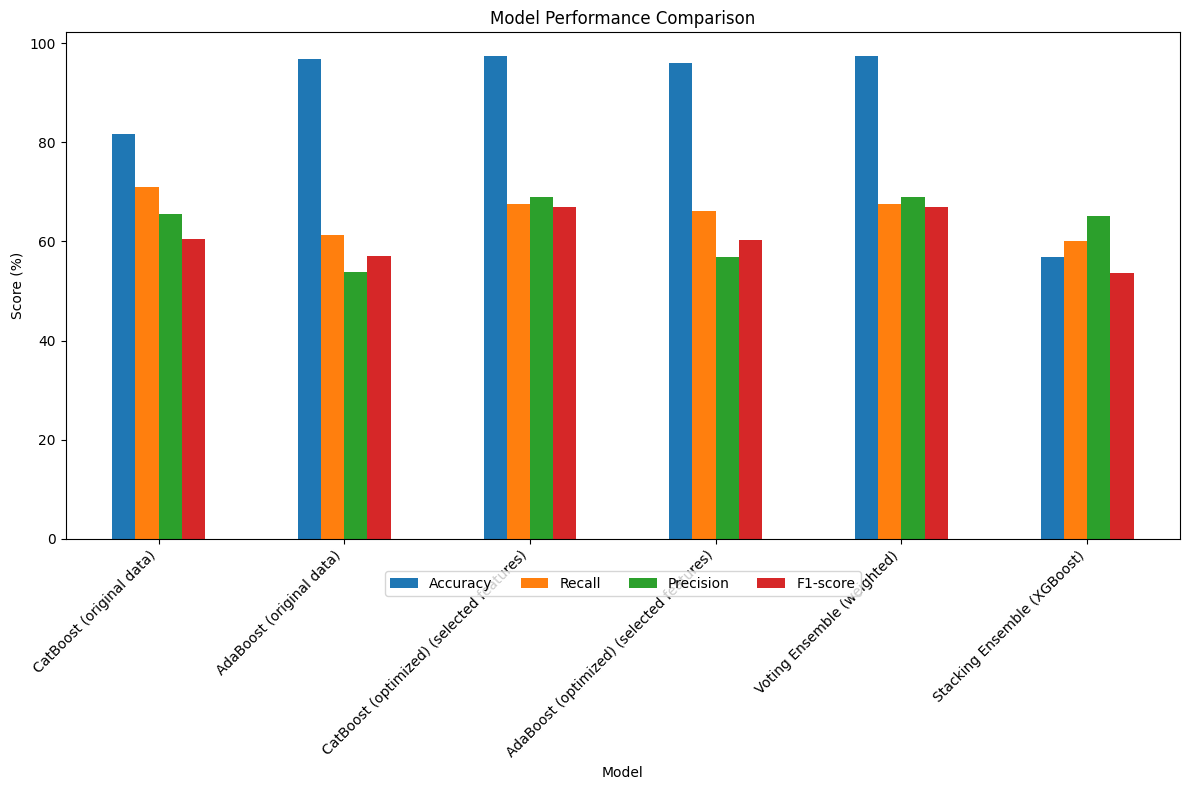

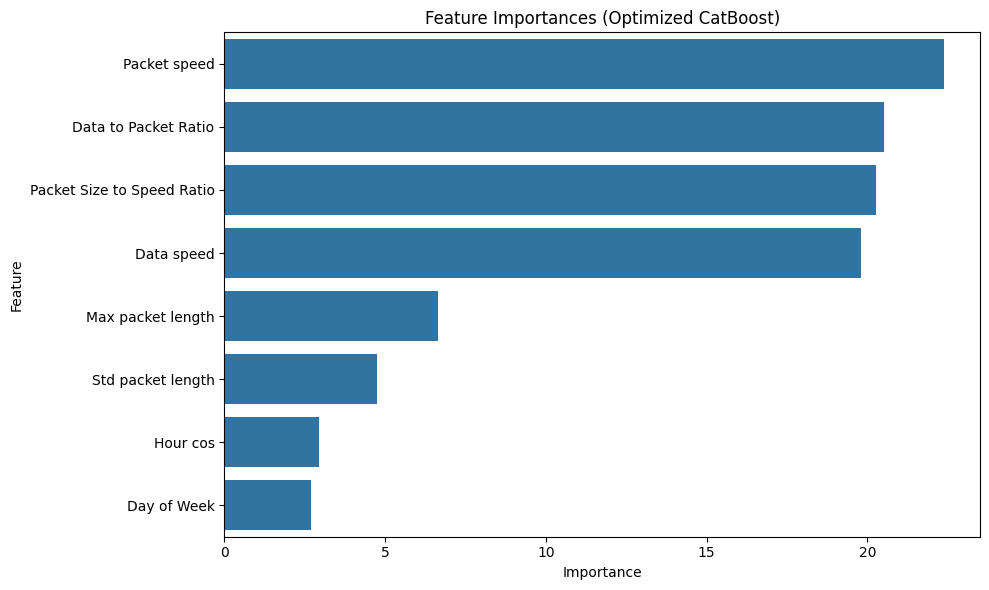


Best models saved to disk.

Completed feature selection, model optimization, and ensemble creation.

Final selected features for CatBoost:
['Data to Packet Ratio', 'Packet Size to Speed Ratio', 'Packet speed', 'Data speed', 'Max packet length', 'Hour cos', 'Day of Week', 'Std packet length']

Final selected features for RFECV:


NameError: name 'rfecv_selected_features' is not defined

In [25]:
#####################################################
# FINAL COMPARISON
#####################################################

# Create results DataFrame
results_df = pd.DataFrame(results).T
print("\n=== Final Comparison ===")
print(results_df)

# Visualize results
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score (%)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.savefig('model_comparison.png')
plt.show()

# Get feature importance from the best model (CatBoost)
catboost_optimized.fit(X_train_catboost_selected, y_train_encoded)
feature_importances = catboost_optimized.get_feature_importance()
feature_names = X_train_catboost_selected.columns

# Create and plot feature importance DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances (Optimized CatBoost)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Save the best models
import joblib
joblib.dump(best_catboost, 'best_catboost_model.pkl')
joblib.dump(best_adaboost, 'best_adaboost_model.pkl')
joblib.dump(meta_learner, 'stacking_meta_learner.pkl')

print("\nBest models saved to disk.")
print("\nCompleted feature selection, model optimization, and ensemble creation.")

# Return the final selected features for documentation
print("\nFinal selected features for CatBoost:")
print(catboost_selected_features)
print("\nFinal selected features for RFECV:")
print(rfecv_selected_features)